# Lompe synthetic demo

Notebook to demonstrate the Lompe technique using synthetic simulated data, MHD simulation output values, as input. This means that we have perfect coverage and no uncertainty in the input, and we know what the output should be. To produce the synthetic data, we simulate the magnetospheric response to a solar wind pressure increase using the the Grid Agnostic MHD for Extended Research Applications (GAMERA) code ([Zhang et al. 2019](https://doi.org/10.3847/1538-4365/ab3a4c); [Sorathia et al. 2020](https://doi.org/10.1029/2020GL088227)). 

Start by importing relevant modules:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import numpy as np
import xarray as xr
import pandas as pd
import lompe
from scipy.interpolate import griddata, interp2d, RectBivariateSpline

Load GAMERA / ReMIX data:

In [2]:
KIND = 'global' # set to 'local' or 'global', depending on which grid you want

# Set datadir to the location of the netcdf file containing GAMERA data
datadir = '../sample_dataset/'
ncfile = 'gamera.nc'

assert os.path.exists(datadir + ncfile), "Can't find datafile!"

# load the GAMERA datafile
with xr.open_dataset(datadir + ncfile) as ds:
    fac       = ds['FAC'].values
    potential = ds['potential'].values
    En        = -ds['Etheta'].values
    Ee        = ds['Ephi'].values
    SP        = ds['SigmaPed'].values
    SH        = ds['SigmaHall'].values
    dBr       = ds['dBg_r'].values    
    dBn       = -ds['dBg_theta'].values
    dBe       = ds['dBg_phi'].values
    dBr_space = ds['dBspace_r'].values    
    dBn_space = -ds['dBspace_theta'].values
    dBe_space = ds['dBspace_phi'].values  
    hemi      = ds['hemi'].values
    mlatt     = ds['mlat'].values
    mltt      = ds['mlt'].values
    simtime   = pd.Timestamp(ds['time'].values).to_pydatetime()
    simtimestr = simtime.strftime("%Y-%m-%d %H:%M:%S")
    remixperturbations__dtype = 'ground_mag'

mlt, mlat = np.meshgrid(mltt, mlatt)

Set up cubed sphere grid and interpolate all quantities from GAMERA to that grid

In [3]:
if KIND == 'global':
    position = (0, 90) # lon, lat for center of the grid
    orientation = 0.
    L, W, Lres, Wres = 15000e3, 15000e3, 200.e3, 200.e3 # dimensions and resolution of grid, in meters

if KIND == 'local':
    position = (180 + 60, 74) # lon, lat for center of the grid
    orientation = 45.
    L, W, Lres, Wres = 3000e3, 3000e3, 75.e3, 75.e3 # dimensions and resolution of grid, in meters


# inner grid:
grid = lompe.cs.CSgrid(lompe.cs.CSprojection(position, orientation), L, W, Lres, Wres, R = 6380e3 + 120e3)

# construct an outer grid, similar to that in the Emodel class:
xi_e  = np.hstack((grid.xi_mesh[0]    , grid.xi_mesh [0 , - 1] + grid.dxi )) - grid.dxi /2 
eta_e = np.hstack((grid.eta_mesh[:, 0], grid.eta_mesh[-1,   0] + grid.deta)) - grid.deta/2 
grid2 = lompe.cs.CSgrid(lompe.cs.CSprojection(grid.projection.position, grid.projection.orientation),
                                  grid.L + grid.Lres, grid.W + grid.Wres, grid.Lres, grid.Wres, 
                                  edges = (xi_e, eta_e), R = grid.R)

def interptogrid(grid, lon, lat, data):
    
    # "G" means Gamera
    xiG, etaG = grid.projection.geo2cube(lon,lat)
    datainterp = griddata((xiG,etaG),data.flatten(), (grid.xi.flatten(),grid.eta.flatten()))
    datainterp = datainterp.reshape(grid.xi.shape)
    
    return datainterp

# interpolate some of the GAMERA output to regular grid:
iii = grid.ingrid(mlt*15, mlat, ext_factor = 1.5)
lonlatcoords  = np.vstack((mlt[iii].flatten() * 15, mlat[iii].flatten()))

SHinterp      = interptogrid(grid , *lonlatcoords, SH[iii].flatten())
SPinterp      = interptogrid(grid , *lonlatcoords, SP[iii].flatten())
potinterp     = interptogrid(grid , *lonlatcoords, potential[iii].flatten())
facinterp     = interptogrid(grid , *lonlatcoords, fac[iii].flatten() * 1e-6)
mltinterp     = interptogrid(grid , *lonlatcoords, mlt[iii]. flatten())
mlatinterp    = interptogrid(grid , *lonlatcoords, mlat[iii].flatten())
Eninterp      = interptogrid(grid , *lonlatcoords, En[iii].flatten())
Eeinterp      = interptogrid(grid , *lonlatcoords, Ee[iii].flatten())
dBrinterp     = interptogrid(grid2, *lonlatcoords, dBr[iii].flatten())
dBninterp     = interptogrid(grid2, *lonlatcoords, dBn[iii].flatten())
dBeinterp     = interptogrid(grid2, *lonlatcoords, dBe[iii].flatten())
dBrsinterp    = interptogrid(grid2, *lonlatcoords, dBr_space[iii].flatten())
dBnsinterp    = interptogrid(grid2, *lonlatcoords, dBn_space[iii].flatten())
dBesinterp    = interptogrid(grid2, *lonlatcoords, dBe_space[iii].flatten())


assert (np.sum(~np.isfinite(SPinterp)) + np.sum(~np.isfinite(SHinterp))) == 0

# conductances
SHfuncCS0 = RectBivariateSpline(grid.xi[0], grid.eta[:,0], SHinterp.T)
SPfuncCS0 = RectBivariateSpline(grid.xi[0], grid.eta[:,0], SPinterp.T)
SHfuncCS = lambda xi, eta : SHfuncCS0(xi, eta, grid = False)
SPfuncCS = lambda xi, eta : SPfuncCS0(xi, eta, grid = False)

def SPfunc(lon, lat):
    ''' Pedersen conductance on grid'''
    xit, etat = grid.projection.geo2cube(lon, lat)
    return SPfuncCS(xit, etat)


def SHfunc(lon, lat):
    ''' Hall conductance on grid'''
    xit, etat = grid.projection.geo2cube(lon, lat)
    return SHfuncCS(xit, etat)

Plot the GAMERA output:

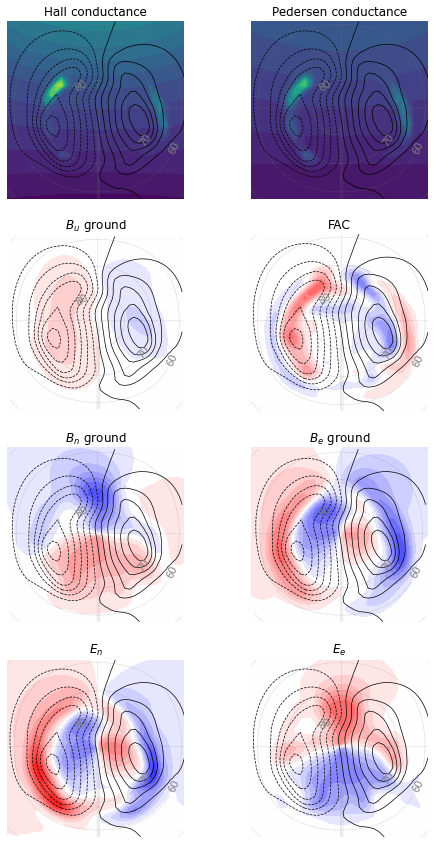

In [4]:
fig, axes = plt.subplots(ncols = 2, nrows = 4, figsize = (8, 15))

axes[0, 0].contourf(grid.xi, grid.eta, SHinterp, levels = np.linspace(0, 30, 25))
axes[0, 0].set_title('Hall conductance')

axes[0, 1].contourf(grid.xi, grid.eta, SPinterp, levels = np.linspace(0, 30, 25))
axes[0, 1].set_title('Pedersen conductance')

axes[1, 1].contourf(grid.xi, grid.eta, facinterp, cmap = plt.cm.bwr, levels = np.linspace(-2e-6, 2e-6, 22))
axes[1, 1].set_title('FAC')

axes[1, 0].contourf(grid2.xi, grid2.eta, dBrsinterp, cmap = plt.cm.bwr, levels = np.linspace(-500e-9, 500e-9, 22))
axes[1, 0].set_title('$B_u$ ground')

axes[2, 0].contourf(grid2.xi, grid2.eta, dBnsinterp, cmap = plt.cm.bwr, levels = np.linspace(-500e-9, 500e-9, 22))
axes[2, 0].set_title('$B_n$ ground')

axes[2, 1].contourf(grid2.xi, grid2.eta, dBesinterp, cmap = plt.cm.bwr, levels = np.linspace(-500e-9, 500e-9, 22))
axes[2, 1].set_title('$B_e$ ground')

axes[3, 0].contourf(grid.xi, grid.eta, Eninterp, cmap = plt.cm.bwr, levels = np.linspace(-80e-3, 80e-3, 22))
axes[3, 0].set_title('$E_n$')

axes[3, 1].contourf(grid.xi, grid.eta, Eeinterp, cmap = plt.cm.bwr, levels = np.linspace(-80e-3, 80e-3, 22))
axes[3, 1].set_title('$E_e$')

# adding potential contours
for ax in axes.flatten():
    c = ax.contour(grid.xi, grid.eta, mlatinterp, levels = [50, 60, 70, 80], linestyles = ':', colors = 'gray', linewidths = .4)
    ax.clabel(c, c.levels, inline = True, fontsize = 10)
    ax.contour(grid.xi, grid.eta, mltinterp, levels = [6, 12, 18], linestyles = ':', colors = 'gray', linewidths = .4)
    ax.contour(grid.xi, grid.eta, potinterp, levels = np.r_[-200:201:10], colors = 'black', linewidths = .7)    

    ax.set_aspect('equal')
    ax.set_axis_off()

Create data objects for Lompe from the GAMERA output:

In [5]:
rg = np.full(grid2.lat.size, 6380e3)
rs = np.full(grid2.lat.size, 6380e3 + 1000e3)

# electric field
Edata = lompe.Data(np.vstack((Eeinterp.flatten(), Eninterp.flatten())),
                   np.vstack((grid.lon.flatten(), grid.lat.flatten())), datatype='efield')

# magnetic field on ground (east, north, up)
Begdata = lompe.Data(dBeinterp.flatten(), np.vstack((grid2.lon.flatten(), grid2.lat.flatten(), rg)),
                     components = 0, datatype = 'ground_mag')
Bngdata = lompe.Data(dBninterp.flatten(), np.vstack((grid2.lon.flatten(), grid2.lat.flatten(), rg)),
                     components = 1, datatype = 'ground_mag')
Bugdata = lompe.Data(dBrinterp.flatten(), np.vstack((grid2.lon.flatten(), grid2.lat.flatten(), rg)),
                     components = 2, datatype = 'ground_mag')

# magnetic field on space (east, north, up)
Besdata = lompe.Data(dBesinterp.flatten(), np.vstack((grid2.lon.flatten(), grid2.lat.flatten(), rs)),
                     components = 0, datatype = 'space_mag_full')
Bnsdata = lompe.Data(dBnsinterp.flatten(), np.vstack((grid2.lon.flatten(), grid2.lat.flatten(), rs)),
                     components = 1, datatype = 'space_mag_full')
Busdata = lompe.Data(dBrsinterp.flatten(), np.vstack((grid2.lon.flatten(), grid2.lat.flatten(), rs)),
                     components = 2, datatype = 'space_mag_full')

# field-aligned current
FACdata = lompe.Data(facinterp.flatten() * grid2.R / rs.flatten()[0], np.vstack((grid.lon.flatten(), grid.lat.flatten())),
                      datatype = 'fac')

# corresponding names and regularization for the data sets
names = ['Electric field', 'FAC', 'Ground $B_e$', 'Ground $B_n$', 'Ground $B_u$', 'Space $B_e$', 'Space $B_n$', 'Space $B_u$']
datasets = [Edata, FACdata, Begdata, Bngdata, Bugdata, Besdata, Bnsdata, Busdata]
regparams = np.array([0, 0, 10, 10, 10, 10, 10, 10]) * 1e-2

datasets = dict(zip(names, datasets))
regparams = dict(zip(names, regparams))

Create Lompe model object

In [6]:
emodel = lompe.Emodel(grid, Hall_Pedersen_conductance=(SHfunc, SPfunc), dipole = True)

gridB = emodel.grid_J
grid2 = emodel.grid_E

inclination = np.arctan(2 * np.tan(gridB.lat * np.pi / 180))

Vary the input and compare the output to simulation and plot overview figure

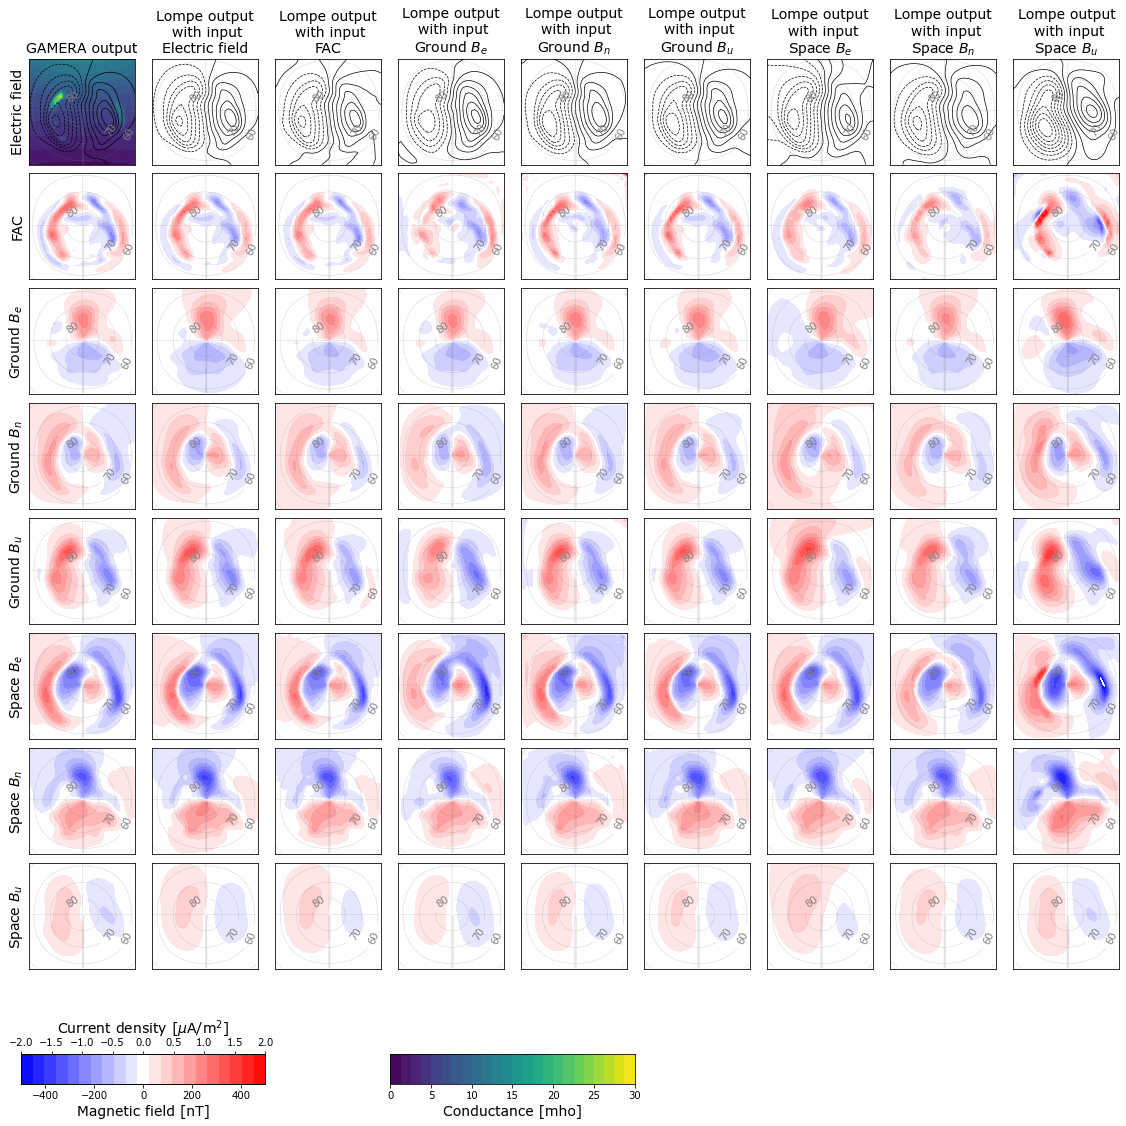

In [7]:
# set up the subplots:
ncols = len(names) + 1 
nrows = len(names)
res = 3 # the colorbars will be 1/res the height of the other plots

gs = gridspec.GridSpec(ncols * res, res * nrows + res)

fig = plt.figure(figsize = (16, 16))
gs = gridspec.GridSpec(ncols * res, res * nrows + res)
axes = np.array([[plt.subplot(gs[(i * res):(i+1)*res, (j*res):(j+1)*res]) for j in range(ncols)] for i in range(nrows)])

# color scales:
blevels = np.linspace(-500e-9, 500e-9, 22) # B color levels
jlevels = np.linspace(-2e-6, 2e-6, 22)     # FAC color levels 
clevels = np.linspace(0, 30, 25)           # conductance color levels

for i in range(nrows):
    # vary data input to Lompe
    emodel.clear_model()
    emodel.add_data(datasets[names[i]])
    # run inversion
    gtg, gtd = emodel.run_inversion(l1 = regparams[names[i]], l2 = 0)

    fac = emodel.FAC().reshape(gridB.shape)

    pot = emodel.E_pot().reshape(gridB.shape) * 1e-3

    pot = pot + potinterp[0, 0] - pot[0, 0] # add a constant to fitted potential to align with original
    
    # plot the Lompe output
    axes[0, i+1].contour(gridB.xi, gridB.eta, pot, levels = np.r_[-200:201:10], colors = 'black', linewidths = .7)
    axes[1, i+1].contourf(gridB.xi, gridB.eta, fac, cmap = plt.cm.bwr, levels = np.linspace(-2e-6, 2e-6, 22))

    B_ground = emodel.B_ground(r = rg)
    axes[2, i+1].contourf(grid2.xi, grid2.eta, B_ground[0].reshape(grid2.shape), cmap = plt.cm.bwr, levels = np.linspace(-500e-9, 500e-9, 22))
    axes[3, i+1].contourf(grid2.xi, grid2.eta, B_ground[1].reshape(grid2.shape), cmap = plt.cm.bwr, levels = np.linspace(-500e-9, 500e-9, 22))
    axes[4, i+1].contourf(grid2.xi, grid2.eta, B_ground[2].reshape(grid2.shape), cmap = plt.cm.bwr, levels = np.linspace(-500e-9, 500e-9, 22))

    B_space = emodel.B_space(r = rs)
    axes[5, i+1].contourf(grid2.xi, grid2.eta, B_space[0].reshape(grid2.shape), cmap = plt.cm.bwr, levels = np.linspace(-500e-9, 500e-9, 22))
    axes[6, i+1].contourf(grid2.xi, grid2.eta, B_space[1].reshape(grid2.shape), cmap = plt.cm.bwr, levels = np.linspace(-500e-9, 500e-9, 22))
    axes[7, i+1].contourf(grid2.xi, grid2.eta, B_space[2].reshape(grid2.shape), cmap = plt.cm.bwr, levels = np.linspace(-500e-9, 500e-9, 22))

    if i == 0:
        for j in range(nrows):
            axes[ 0, j + 1].set_title('Lompe output\n with input\n' + names[j], size = 14)
    
# plot GAMERA output in first row:
axes[0, 0].contourf(grid.xi, grid.eta, SHinterp  , levels = np.linspace(0, 30, 25))
axes[0, 0].contour( grid.xi, grid.eta, potinterp , levels = np.r_[-200:201:10], colors = 'black', linewidths = .7)    
axes[1, 0].contourf(grid.xi, grid.eta, facinterp , cmap = plt.cm.bwr, levels = np.linspace(-2e-6, 2e-6, 22))
axes[2, 0].contourf(grid2.xi, grid2.eta, dBeinterp , cmap = plt.cm.bwr, levels = np.linspace(-500e-9, 500e-9, 22))
axes[3, 0].contourf(grid2.xi, grid2.eta, dBninterp , cmap = plt.cm.bwr, levels = np.linspace(-500e-9, 500e-9, 22))
axes[4, 0].contourf(grid2.xi, grid2.eta, dBrinterp , cmap = plt.cm.bwr, levels = np.linspace(-500e-9, 500e-9, 22))
axes[5, 0].contourf(grid2.xi, grid2.eta, dBesinterp, cmap = plt.cm.bwr, levels = np.linspace(-500e-9, 500e-9, 22))
axes[6, 0].contourf(grid2.xi, grid2.eta, dBnsinterp, cmap = plt.cm.bwr, levels = np.linspace(-500e-9, 500e-9, 22))
axes[7, 0].contourf(grid2.xi, grid2.eta, dBrsinterp, cmap = plt.cm.bwr, levels = np.linspace(-500e-9, 500e-9, 22))

for i in range(nrows):
    axes[i, 0].set_ylabel(names[i], size = 14)

axes[ 0, 0].set_title('GAMERA output', size = 14)

# add magnetic latitude and mlt to plots
for ax in axes.flatten():
    c = ax.contour(grid.xi, grid.eta, mlatinterp, levels = [50, 60, 70, 80], linestyles = ':', colors = 'gray', linewidths = .4)
    ax.clabel(c, c.levels, inline=True, fontsize=10)
    ax.contour(grid.xi, grid.eta, mltinterp, levels = [6, 12, 18], linestyles = ':', colors = 'gray', linewidths = .4)

    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    

# draw colorbars:
cbar_ax1  = plt.subplot(gs[ncols * res - 1, 0:res*2])
cbar_ax1_ = plt.twiny(cbar_ax1)
cbar_ax1_.set_xlim(jlevels[0]*1e6, jlevels[-1]*1e6)
cbar_ax1_.set_xlabel('Current density [$\mu$A/m$^2$]', size = 14)

cbar_ax1.contourf(np.vstack((blevels, blevels))*1e9, np.vstack((blevels*0, blevels*0+1)), np.vstack((blevels, blevels)), cmap = plt.cm.bwr, levels = blevels)
cbar_ax1.set_xlabel('Magnetic field [nT]', size = 14)

cbar_ax2 = plt.subplot(gs[ncols * res - 1, 3*res:5*res])
cbar_ax2.contourf(np.vstack((clevels, clevels)), np.vstack((clevels*0, clevels*0+1)), np.vstack((clevels, clevels)), levels = clevels)
cbar_ax2.set_xlabel('Conductance [mho]', size = 14)

# adjust plots, remove axis labels
for ax in [cbar_ax1, cbar_ax2]: ax.set_yticks([])
plt.subplots_adjust(left = 0.03, right = .99, top = .94, bottom = .05, wspace = 5e-2, hspace = 3e-1)

# save figure
fig.savefig('./output_figures/GAMERA_comparison_' + KIND + '.pdf')
fig.savefig('./output_figures/GAMERA_comparison_' + KIND + '.png')

The figure now shows the results of Lompe inversions with synthetic data from GAMERA (shown in the left column). The rest of the columns show the Lompe inversion outputs. The eight rows correspond to eight different inputs to the inversion, indicated above the top row. The inversion result can be assessed by comparing the plots to the left column with GAMERA output (figure constructed earlier in notebook), which can be considered to be the ground truth in this experiment.